# Convolutional Neural Networks

In [1]:
#Realizaremos un ejercicio descrito en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.

# Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [23]:
import keras
#from keras.utils import to_categorical
#from keras.models import Sequential,Input,Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow import keras

# Cargar set de Imágenes

In [4]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\dev\tfg\src\selector-deportes\sportimages\
C:\dev\tfg\src\selector-deportes\sportimages\americano 1
C:\dev\tfg\src\selector-deportes\sportimages\basket 9348
C:\dev\tfg\src\selector-deportes\sportimages\beisball 8823
C:\dev\tfg\src\selector-deportes\sportimages\boxeo 7752
C:\dev\tfg\src\selector-deportes\sportimages\ciclismo 7125
C:\dev\tfg\src\selector-deportes\sportimages\f1 7533
C:\dev\tfg\src\selector-deportes\sportimages\futbol 5053
C:\dev\tfg\src\selector-deportes\sportimages\golf 7617
C:\dev\tfg\src\selector-deportes\sportimages\natacion 9768
C:\dev\tfg\src\selector-deportes\sportimages\tenis 5172
Directorios leidos: 10
Imagenes en cada directorio [9349, 8823, 7752, 7125, 7533, 5053, 7617, 9768, 5172, 8936]
suma Total de imagenes en subdirs: 77128


# Creamos las etiquetas

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [6]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


In [7]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [8]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 3')

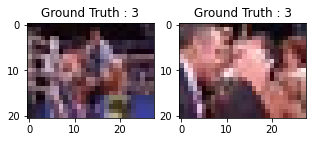

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [11]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [12]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [13]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [14]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [15]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [16]:
sport_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 28, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 21, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4928)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                157728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

In [30]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [31]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/6
772/772 [==============================] - 18s 21ms/step - loss: 2.1556 - accuracy: 0.2160 - val_loss: 1.8380 - val_accuracy: 0.5109
Epoch 2/6
772/772 [==============================] - 17s 22ms/step - loss: 1.8049 - accuracy: 0.3855 - val_loss: 1.4767 - val_accuracy: 0.6326
Epoch 3/6
772/772 [==============================] - 17s 22ms/step - loss: 1.5781 - accuracy: 0.4678 - val_loss: 1.2803 - val_accuracy: 0.6901
Epoch 4/6
772/772 [==============================] - 17s 22ms/step - loss: 1.4335 - accuracy: 0.5157 - val_loss: 1.1523 - val_accuracy: 0.7176
Epoch 5/6
772/772 [==============================] - 17s 22ms/step - loss: 1.3317 - accuracy: 0.5553 - val_loss: 1.0570 - val_accuracy: 0.7401
Epoch 6/6
772/772 [==============================] - 17s 22ms/step - loss: 1.2544 - accuracy: 0.5771 - val_loss: 0.9850 - val_accuracy: 0.7501


In [32]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

INFO:tensorflow:Assets written to: sports_mnist.h5py\assets


# Evaluamos la red

In [33]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

483/483 [==============================] - 2s 4ms/step - loss: 0.9906 - accuracy: 0.7527


In [34]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9905751943588257
Test accuracy: 0.7526902556419373


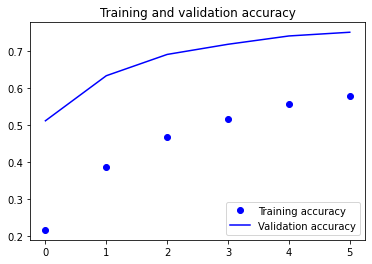

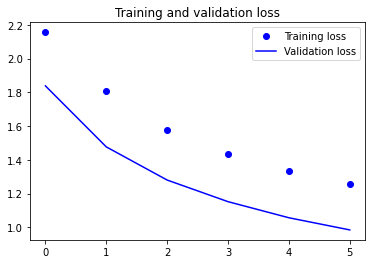

In [37]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [38]:
predicted_classes2 = sport_model.predict(test_X)

In [39]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [40]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 11611 correct labels


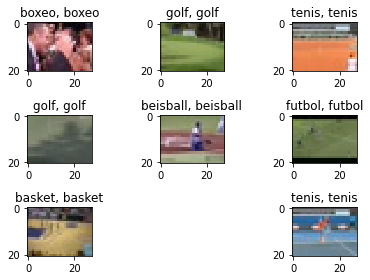

In [41]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 3815 incorrect labels


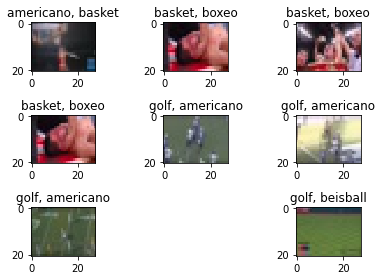

In [42]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [43]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.48      0.34      0.40      1913
     Class 1       0.80      0.86      0.83      1853
     Class 2       0.74      0.70      0.72      1517
     Class 3       0.73      0.86      0.79      1379
     Class 4       0.95      0.98      0.96      1481
     Class 5       0.87      0.22      0.35      1040
     Class 6       0.82      0.78      0.80      1470
     Class 7       0.57      0.88      0.69      1931
     Class 8       0.91      0.77      0.83      1036
     Class 9       0.91      1.00      0.95      1806

    accuracy                           0.75     15426
   macro avg       0.78      0.74      0.73     15426
weighted avg       0.76      0.75      0.74     15426



# Prediccion de una nueva imagen

In [45]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['test/golf_0113.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

test/golf_0113.jpg golf
